Скачиваем и импортируем нужные для работы библиотеки

In [1]:
!pip install jupyter ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 9.3 MB/s eta 0:00:00


In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from statistics import mean
from google.colab import output
from IPython.display import clear_output

Здесь и далее *connections* -- словарь списков, описывающий связи в графе. Определим функцию, принимающую этот словарь и границы размера населения, возвращающую словарь с ключами -- городами и значениями -- произвольными значениями изначального населения городов.

In [3]:
def random_population(connections: dict, min: int, max: int) -> dict:
  cities = connections.keys()
  population = dict()
  for city in cities:
    population[city] = random.randint(min, max)
  return population

Определим функцию, принимающую словарь связи и возвращающую словарь изначального заражения (везде 0 и в одном месте 1).

In [4]:
def zero_patient(connections: dict) -> dict:
  cities = connections.keys()
  illness = dict()
  for city in cities:
    illness[city] = 0
  illness[random.choice(list(connections.keys()))] = 1
  return illness

Порядок распространения болезни будет следующим. В течение дня все происходит в следующем порядке:

1.   Каждый город получает 0, 1 или 2 больного в зависимости от условий, сложившихся в начале дня.
2.   Города, в которых больше половины больны, лишаются половины больных.
3.   Один сосед каждого из "ополовиненных" городов получает больного.
4.   Пункты 3 и 4 повторяются, пока во всех городах не будет больше половины больных.



Функция, принимающая три числа: размер населения, число больных, число новых заболевших. Она возвращает финальное количество больных (с условием того, что больных не может быть больше общего населения).

In [5]:
def add_ill(total: int, ill: int, new: int) -> int:
  if ill + new > total:
    return total
  else:
    return ill + new

Функция которая по связям, сотоянию болезни и городу возвращает количество новых больных в городе (0 -- в городе нет больных, 1 -- в городе, но не в соседних больные, 2 -- больные и в городе и в соседнем).

In [6]:
def get_number(connections: dict, illness: dict, city: str) -> int:
  if illness[city] == 0:
    return 0
  else:
    neighbors = connections[city]
    ill_near = sum(illness[neighbor] for neighbor in neighbors)
    if ill_near > 0:
      return 2
    else:
      return 1

Функция по связям, населению и болезням к каждому городу добавляет новых больных и возвращает обновленный словарь болезни.

In [7]:
def spread_inside(connections: dict, population: dict,
                  illness: dict) -> dict:
  for city in connections.keys():
    new = get_number(connections, illness, city)
    illness[city] = add_ill(population[city], illness[city], new)
  return illness

Функция, которая по числу возвращает его половину. Для четных понятно, для нечетных округление в рандомную сторону. Для 1 -- 1 (чтобы хоть кто-то умер и чтобы точно не получился длинный цикл, когда в городе болен 1 из 1 и он все никак не умирает).

In [8]:
def half(number: int) -> int:
  if number % 2 == 0:
    return number // 2
  elif number == 1:
    return 1
  else:
    return (number + random.randint(0, 1)) // 2

Функция, которая убивает половину больных в нужных городах и распространяет болезнь на соседей до тех пор, пока условие смерти не перестанет выполняться. Важно, что порядок именно такой: все нужные города теряют половину, все нужные города получают +1.

In [9]:
def halved_spread(connections: dict, population: dict,
                  illness: dict) -> tuple[dict, dict]:
  # список соседей, которые потом получат +1
  spread = []
  # количество ополовиненных городов
  halved_cities = 0
  for city in connections.keys():
    # важно, что в ситуации мертового города, условие не выполняется
    if illness[city] > (population[city] / 2):
      halved_cities += 1
      dead = half(illness[city])
      illness[city] -= dead
      population[city] -= dead
      not_full_neighbors = []
      # находим соседей, которые еще не полные и не полностью мертвые
      for neighbor in connections[city]:
        if population[neighbor] != illness[neighbor]:
          not_full_neighbors.append(neighbor)
      if len(not_full_neighbors) > 0:
        spread.append(random.choice(not_full_neighbors))
  # если ничего не ополовинилось, то возвращаем изначальные данные
  if halved_cities == 0:
    return population, illness
  # если что-то ополовинилось, то делаем +1 и еще раз запускаем функцию
  else:
    for city in spread:
      illness[city] = add_ill(population[city], illness[city], 1)
    return halved_spread(connections, population, illness)

Функция, которая возвращает информацию о населении и болезни через заданное количество дней.

In [10]:
def step_forward(connections: dict, population: dict, illness: dict,
                 step: int) -> tuple[dict, dict]:
  global day
  day += step
  for i in range(step):
    spread_inside(connections, population, illness)
    halved_spread(connections, population, illness)
  return population, illness

Функция, которая отрисовывает граф. Размеры вершин пропорциональны населению, если в городе все умерли, фиксированный размер. Цвета вершин меняются от зеленого до красного в зависимости от доли больных, при смерти всех цвет становится серым.

In [11]:
def draw(connections: dict, population: dict, illness: dict):
  colors = [plt.cm.RdYlGn(1 - illness[city] / population[city])
            if (population[city] != 0) else 'gray' for city in illness.keys()]
  sizes = [population[city] / max * 1000 if (population[city] != 0)
            else 50 for city in population.keys()]
  fig, ax = plt.subplots(1, figsize=(12, 6))
  plt.axis('off')
  fig.canvas.header_visible = False
  plt.title(f"Day {day}", fontdict = {'family':'serif','size':36})
  nx.draw_networkx(G, ax=ax, with_labels=False, pos=nx.kamada_kawai_layout(G),
                   node_color=colors, node_size=sizes)

Перед отрисовкой процесса распространения полезно оценить сколько дней примерно идет болезнь, чтобы оценить шаг, с которым будет вывод.

Функция, которая по текущему состоянию возвращает возможное (потому что часть процессов случайная) количество дней, которое осталось до конца.

In [12]:
def find_end(connections: dict, population: dict, illness: dict) -> int:
  ill_copy = illness.copy()
  pop_copy = population.copy()
  steps = 0
  while sum(ill[1] for ill in ill_copy.items()) != 0:
    spread_inside(connections, pop_copy, ill_copy)
    halved_spread(connections, pop_copy, ill_copy)
    steps += 1
  return steps

Если граф не очень большой, то можно более точно определить количество дней до конца как среднее нескольких возможных (один раз может получиться какой-то крайний).

In [13]:
def find_end_mean(connections: dict, population: dict,
                  illness: dict, itters: int) -> float:
  ends = [find_end(connections, population, illness) for i in range(itters)]
  return mean(ends)

Смоделируем распространение болезни на примере не очень большого случайного связного графа. Словарь связей получим при помощи существующей функции. Также зададим случайное население и выберем стартовый для болезни город.

In [14]:
G = nx.connected_watts_strogatz_graph(25, 4, 0.5)
connections = nx.to_dict_of_lists(G)
min, max = 100, 1000
population = random_population(connections, min, max)
illness = zero_patient(connections)
day = 1

Оценим полное количество дней.

In [15]:
find_end(connections, population, illness)

1231

И чуть точнее.

In [16]:
find_end_mean(connections, population, illness, 100)

1195

В специальном окне matplotlib (чтобы убирать предыдущую картинку) выводим первый день, а затем делаем шаг и выводим новый день. До тех пор, пока все не закончится (все больные умерли).

Если шаг не 1, то последний выведенный день необязательно равен последнему дню болезни (ошибка не больше шаг-1).

In [17]:
output.enable_custom_widget_manager()

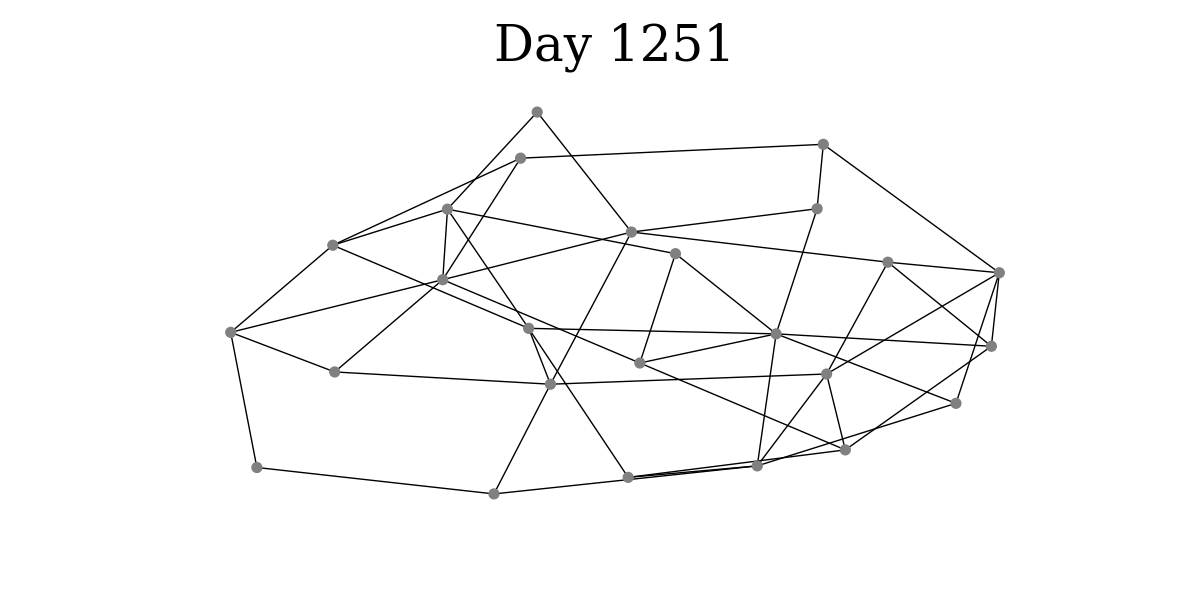

In [18]:
%matplotlib widget
step, wait = 50, 1
draw(connections, population, illness)
plt.pause(wait)
while sum(ill[1] for ill in illness.items()) != 0:
  clear_output(wait=True)
  population, illness = step_forward(connections, population, illness, step)
  draw(connections, population, illness)
  plt.pause(wait)